# Multivariate bias adjustment workflow

This notebook provides an example workflow for multivariate bias adjustment (MBA) in the context of 
thermal stress. The workflow uses four input variables (air temperature, relative humidity, wind speed, 
and downwelling solar radiation) to calculate mean radiant temperature (Tmrt), and the Universal Thermal 
Climate Index (UTCI). We use the BARRA reanalysis (Su et al., 2021) as our historical observations, and the CSIRO's ACCCESS1-0 model, dynamically downscaled by Harris et al. (2020) and Clarke et al. (2019). The workflow makes significant use of the compatability of the xclim and xarray packages.

To achieve this, we emply a diurnal version of Cannon's N-dimensional multivariate bias correction (MBCn)
(2018), guided by the work of Faghih (2022). Each variable undergoes individual bias adjustment in the 
form of Quantile Delta Mapping (QDM) (Cannon et al., 2015). These adjustments are multiplicative for all
variables. To retain diurnal and annual cycles, inputs are grouped by hour of the day and week of the year, with weeks 52 and 53 combined to avoid week 53 containing few data points. 30 quantiles are used for each group. Mismatches in solar radiation between our historic model outputs and "observations" (reanalysis) very occasionally lead to infinite adjustment factors. Accordingly, we set these adjustment factors to zero. This occurred in 0.065% of cases for the six models in Weeding et al. (2023). 

Once each input variable is individually adjusted, the variables are adjusted as a group using the 
MBCn algorithm. Bias adjusted inputs are grouped by hour of the day and day of the year to retain the 
diurnal and annual cycles as strongly as possible. 20 quantiles were used per group, and 20 iterations 
performed. 


In [1]:
# import packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import LogNorm
import sys
import xclim
from xclim import sdba
from xclim.sdba.adjustment import QuantileDeltaMapping
import cftime
from tabulate import tabulate
from dask import compute
from dask.diagnostics import ProgressBar

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
# We import the historic "observations" (in this case BARRA reanalysis),
ds_barra = xr.open_zarr('/scratch/bweeding/SOLWEIG_testing/BARRA/bw_alldata_UTCI.zarr',chunks=None)

# the historic model outputs,
ds_model_hist = xr.open_zarr('/scratch/bweeding/SOLWEIG_testing/CSIRO_BOM_ACCESS1_0/hist/bw_alldata_UTCI.zarr',chunks=None)

# and the future model ouputs.
ds_model_proj = xr.open_zarr('/scratch/bweeding/SOLWEIG_testing/CSIRO_BOM_ACCESS1_0/proj/bw_alldata_UTCI.zarr',chunks=None)

# We trim the observations and historic model outputs to overlap in time exactly
start_time = ds_barra.timestamp[0]
end_time = ds_model_hist.timestamp[-1]

ds_barra = ds_barra.sel(timestamp=slice(start_time,end_time))
ds_model_hist = ds_model_hist.sel(timestamp=slice(start_time,end_time))

In [3]:
# We make some adjustments to the imported datasets in order for them to work with xclim
def set_units(ds):
            
    ds = ds.rename({'timestamp':'time'})             # the time dimension must be named "time"
    
    ds['Tair'] = ds['Tair'] + 273.15                 # not required if your temperature is already in Kelvin

    ds['Tair'] = ds.Tair.assign_attrs({'units':'K'}) # xclim requires the variables to have units

    ds['RH'] = ds.RH.assign_attrs({'units':'%'})

    ds['Uwind'] = ds.Uwind.assign_attrs({'units':'m/s'})

    ds['kdown'] = ds.kdown.assign_attrs({'units':'W m^-2'})

    return ds

ds_barra = set_units(ds_barra)
ds_model_hist = set_units(ds_model_hist)
ds_model_proj = set_units(ds_model_proj)

We begin the individual bias adjustments, starting with air temperature (Tair).

In [4]:
# We make copies of the model outputs that will be altered by the bias adjusting
Tair_hist_adjusted_QDM =  ds_model_hist.Tair.copy()

Tair_proj_adjusted_QDM = ds_model_proj.Tair.copy()

# We group the outputs by hour of the day and...
for cur_hour in np.arange(0,24,1):
    
    # week of the year. We don't include week 53 in this index as it is captured with week 52.
    for cur_week in np.arange(1,53,1):
        
        # Here we combine outputs for weeks 52 and 53
        if cur_week == 52:
            
            # For each combination of hour of the day and week of the year we train a Quantile Delta Mapping
            # (QDM) object on the group of outputs, with 30 quantiles (nquantiles=30) and multiplicative 
            # adjustment (kind="*"). As we have already grouped the inputs, we instruct the QDM object not to
            # perform any grouping on the time dimension (group="time")
            QDM_Tair = sdba.QuantileDeltaMapping.train(
                ds_barra.Tair[(ds_barra.Tair.time.dt.hour==cur_hour)&(np.isin(ds_barra.Tair.time.dt.isocalendar().week,np.array([52,53])))], 
                ds_model_hist.Tair[(ds_model_hist.Tair.time.dt.hour==cur_hour)&(np.isin(ds_model_hist.Tair.time.dt.isocalendar().week,np.array([52,53])))], 
                nquantiles=30, kind="*", group="time")
            
            # We create time indices for groups of hour of the day and week of the year that combine
            # weeks 52 and 53 to insert the adjusted data 
            hist_time_idx = (Tair_hist_adjusted_QDM.time.dt.hour==cur_hour)&(np.isin(Tair_hist_adjusted_QDM.time.dt.isocalendar().week,np.array([52,53])))

            proj_time_idx = (Tair_proj_adjusted_QDM.time.dt.hour==cur_hour)&(np.isin(Tair_proj_adjusted_QDM.time.dt.isocalendar().week,np.array([52,53])))

            # We adjust the model outputs and insert the adjusted data into the copies of the model outputs
            Tair_hist_adjusted_QDM[hist_time_idx] = QDM_Tair.adjust(ds_model_hist.Tair[hist_time_idx],interp='nearest')

            Tair_proj_adjusted_QDM[proj_time_idx] = QDM_Tair.adjust(ds_model_proj.Tair[proj_time_idx],interp='nearest')

        # for all other weeks we perform the same process as above    
        else:

            # For each combination of hour of the day and week of the year we train a Quantile Delta Mapping
            # (QDM) object on the group of outputs, with 30 quantiles (nquantiles=30) and multiplicative 
            # adjustment (kind="*"). As we have already grouped the inputs, we instruct the QDM object not to
            # perform any grouping on the time dimension (group="time")
            QDM_Tair = sdba.QuantileDeltaMapping.train(
                ds_barra.Tair[(ds_barra.Tair.time.dt.hour==cur_hour)&(ds_barra.Tair.time.dt.isocalendar().week==cur_week)], 
                ds_model_hist.Tair[(ds_model_hist.Tair.time.dt.hour==cur_hour)&(ds_model_hist.Tair.time.dt.isocalendar().week==cur_week)], 
                nquantiles=30, kind="*", group='time')

            # We create time indices for groups of hour of the day and week of the year to insert the adjusted data 
            hist_time_idx = (Tair_hist_adjusted_QDM.time.dt.hour==cur_hour)&(Tair_hist_adjusted_QDM.time.dt.isocalendar().week==cur_week)

            proj_time_idx = (Tair_proj_adjusted_QDM.time.dt.hour==cur_hour)&(Tair_proj_adjusted_QDM.time.dt.isocalendar().week==cur_week)

            # We adjust the model outputs and insert the adjusted data into the copies of the model outputs
            Tair_hist_adjusted_QDM[hist_time_idx] = QDM_Tair.adjust(ds_model_hist.Tair[hist_time_idx],interp='nearest')

            Tair_proj_adjusted_QDM[proj_time_idx] = QDM_Tair.adjust(ds_model_proj.Tair[proj_time_idx],interp='nearest')

# Once adjustments have been made for all combinations of hour of day and week of year, we create new versions
# of the adjusted data named in accordance with the xclim template
scenh_Tair = Tair_hist_adjusted_QDM
scens_Tair = Tair_proj_adjusted_QDM



We now perform the same process for relative humidity and wind speed.

In [5]:
RH_hist_adjusted_QDM =  ds_model_hist.RH.copy()

RH_proj_adjusted_QDM = ds_model_proj.RH.copy()

for cur_hour in np.arange(0,24,1):
    
    for cur_week in np.arange(1,53,1):
        
        if cur_week == 52:
            
            QDM_RH = sdba.QuantileDeltaMapping.train(
                ds_barra.RH[(ds_barra.RH.time.dt.hour==cur_hour)&(np.isin(ds_barra.RH.time.dt.isocalendar().week,np.array([52,53])))], 
                ds_model_hist.RH[(ds_model_hist.RH.time.dt.hour==cur_hour)&(np.isin(ds_model_hist.RH.time.dt.isocalendar().week,np.array([52,53])))], 
                nquantiles=30, kind="*", group='time')
            
            hist_time_idx = (RH_hist_adjusted_QDM.time.dt.hour==cur_hour)&(np.isin(RH_hist_adjusted_QDM.time.dt.isocalendar().week,np.array([52,53])))

            proj_time_idx = (RH_proj_adjusted_QDM.time.dt.hour==cur_hour)&(np.isin(RH_proj_adjusted_QDM.time.dt.isocalendar().week,np.array([52,53])))

            RH_hist_adjusted_QDM[hist_time_idx] = QDM_RH.adjust(ds_model_hist.RH[hist_time_idx],interp='nearest')

            RH_proj_adjusted_QDM[proj_time_idx] = QDM_RH.adjust(ds_model_proj.RH[proj_time_idx],interp='nearest')

            
        else:
            
            QDM_RH = sdba.QuantileDeltaMapping.train(
                ds_barra.RH[(ds_barra.RH.time.dt.hour==cur_hour)&(ds_barra.RH.time.dt.isocalendar().week==cur_week)], 
                ds_model_hist.RH[(ds_model_hist.RH.time.dt.hour==cur_hour)&(ds_model_hist.RH.time.dt.isocalendar().week==cur_week)], 
                nquantiles=30, kind="*", group='time')
        
            hist_time_idx = (RH_hist_adjusted_QDM.time.dt.hour==cur_hour)&(RH_hist_adjusted_QDM.time.dt.isocalendar().week==cur_week)

            proj_time_idx = (RH_proj_adjusted_QDM.time.dt.hour==cur_hour)&(RH_proj_adjusted_QDM.time.dt.isocalendar().week==cur_week)

            RH_hist_adjusted_QDM[hist_time_idx] = QDM_RH.adjust(ds_model_hist.RH[hist_time_idx],interp='nearest')

            RH_proj_adjusted_QDM[proj_time_idx] = QDM_RH.adjust(ds_model_proj.RH[proj_time_idx],interp='nearest')

scenh_RH = RH_hist_adjusted_QDM
scens_RH = RH_proj_adjusted_QDM

In [6]:
Uwind_hist_adjusted_QDM =  ds_model_hist.Uwind.copy()

Uwind_proj_adjusted_QDM = ds_model_proj.Uwind.copy()

for cur_hour in np.arange(0,24,1):
    
    for cur_week in np.arange(1,53,1):
        
        if cur_week == 52:
            
            QDM_Uwind = sdba.QuantileDeltaMapping.train(
                ds_barra.Uwind[(ds_barra.Uwind.time.dt.hour==cur_hour)&(np.isin(ds_barra.Uwind.time.dt.isocalendar().week,np.array([52,53])))], 
                ds_model_hist.Uwind[(ds_model_hist.Uwind.time.dt.hour==cur_hour)&(np.isin(ds_model_hist.Uwind.time.dt.isocalendar().week,np.array([52,53])))], 
                nquantiles=30, kind="*", group='time')
            
            hist_time_idx = (Uwind_hist_adjusted_QDM.time.dt.hour==cur_hour)&(np.isin(Uwind_hist_adjusted_QDM.time.dt.isocalendar().week,np.array([52,53])))

            proj_time_idx = (Uwind_proj_adjusted_QDM.time.dt.hour==cur_hour)&(np.isin(Uwind_proj_adjusted_QDM.time.dt.isocalendar().week,np.array([52,53])))

            Uwind_hist_adjusted_QDM[hist_time_idx] = QDM_Uwind.adjust(ds_model_hist.Uwind[hist_time_idx],interp='nearest')

            Uwind_proj_adjusted_QDM[proj_time_idx] = QDM_Uwind.adjust(ds_model_proj.Uwind[proj_time_idx],interp='nearest')

            
        else:
            
            QDM_Uwind = sdba.QuantileDeltaMapping.train(
                ds_barra.Uwind[(ds_barra.Uwind.time.dt.hour==cur_hour)&(ds_barra.Uwind.time.dt.isocalendar().week==cur_week)], 
                ds_model_hist.Uwind[(ds_model_hist.Uwind.time.dt.hour==cur_hour)&(ds_model_hist.Uwind.time.dt.isocalendar().week==cur_week)], 
                nquantiles=30, kind="*", group='time')
        
            hist_time_idx = (Uwind_hist_adjusted_QDM.time.dt.hour==cur_hour)&(Uwind_hist_adjusted_QDM.time.dt.isocalendar().week==cur_week)

            proj_time_idx = (Uwind_proj_adjusted_QDM.time.dt.hour==cur_hour)&(Uwind_proj_adjusted_QDM.time.dt.isocalendar().week==cur_week)

            Uwind_hist_adjusted_QDM[hist_time_idx] = QDM_Uwind.adjust(ds_model_hist.Uwind[hist_time_idx],interp='nearest')

            Uwind_proj_adjusted_QDM[proj_time_idx] = QDM_Uwind.adjust(ds_model_proj.Uwind[proj_time_idx],interp='nearest')

scenh_Uwind = Uwind_hist_adjusted_QDM
scens_Uwind = Uwind_proj_adjusted_QDM

We now adjust downwelling solar radiation (kdown) using the same process as for the other variables, but with an additional step. Mismatches in solar radiation between our historic model outputs and "observations" (reanalysis) very occasionally lead to infinite adjustment factors. Accordingly, we set these adjustment factors to zero. We also set any nan outputs to zero. These occur at night-time hours when both the historic outputs and observations have zero value, and aren't accepted by xclim when applying the MBCn algorithm.

In [7]:
kdown_hist_adjusted_QDM =  ds_model_hist.kdown.copy()

kdown_proj_adjusted_QDM = ds_model_proj.kdown.copy()

num_nans = 0
num_infs = 0

for cur_hour in np.arange(0,24,1):
    
    for cur_week in np.arange(1,53,1):
        
        if cur_week == 52:
            
            QDM_kdown = sdba.QuantileDeltaMapping.train(
                ds_barra.kdown[(ds_barra.kdown.time.dt.hour==cur_hour)&(np.isin(ds_barra.kdown.time.dt.isocalendar().week,np.array([52,53])))], 
                ds_model_hist.kdown[(ds_model_hist.kdown.time.dt.hour==cur_hour)&(np.isin(ds_model_hist.kdown.time.dt.isocalendar().week,np.array([52,53])))], 
                nquantiles=30, kind="*", group='time')
            
            # here we set the infinite and nan adjustment factors to zero
            QDM_kdown.ds.af.values = xr.where(QDM_kdown.ds.af==np.inf,0,QDM_kdown.ds.af)
            QDM_kdown.ds.af.values = xr.where(np.isnan(QDM_kdown.ds.af),0,QDM_kdown.ds.af)
            
            hist_time_idx = (kdown_hist_adjusted_QDM.time.dt.hour==cur_hour)&(np.isin(kdown_hist_adjusted_QDM.time.dt.isocalendar().week,np.array([52,53])))

            proj_time_idx = (kdown_proj_adjusted_QDM.time.dt.hour==cur_hour)&(np.isin(kdown_proj_adjusted_QDM.time.dt.isocalendar().week,np.array([52,53])))

            kdown_hist_adjusted_QDM[hist_time_idx] = QDM_kdown.adjust(ds_model_hist.kdown[hist_time_idx],interp='nearest')

            kdown_proj_adjusted_QDM[proj_time_idx] = QDM_kdown.adjust(ds_model_proj.kdown[proj_time_idx],interp='nearest')

            
        else:
            
            QDM_kdown = sdba.QuantileDeltaMapping.train(
                ds_barra.kdown[(ds_barra.kdown.time.dt.hour==cur_hour)&(ds_barra.kdown.time.dt.isocalendar().week==cur_week)], 
                ds_model_hist.kdown[(ds_model_hist.kdown.time.dt.hour==cur_hour)&(ds_model_hist.kdown.time.dt.isocalendar().week==cur_week)], 
                nquantiles=30, kind="*", group='time')

            # here we set the infinite and nan adjustment factors to zero
            QDM_kdown.ds.af.values = xr.where(QDM_kdown.ds.af==np.inf,0,QDM_kdown.ds.af)
            QDM_kdown.ds.af.values = xr.where(np.isnan(QDM_kdown.ds.af),0,QDM_kdown.ds.af)
        
            hist_time_idx = (kdown_hist_adjusted_QDM.time.dt.hour==cur_hour)&(kdown_hist_adjusted_QDM.time.dt.isocalendar().week==cur_week)

            proj_time_idx = (kdown_proj_adjusted_QDM.time.dt.hour==cur_hour)&(kdown_proj_adjusted_QDM.time.dt.isocalendar().week==cur_week)

            kdown_hist_adjusted_QDM[hist_time_idx] = QDM_kdown.adjust(ds_model_hist.kdown[hist_time_idx],interp='nearest')

            kdown_proj_adjusted_QDM[proj_time_idx] = QDM_kdown.adjust(ds_model_proj.kdown[proj_time_idx],interp='nearest')          
            
scenh_kdown = kdown_hist_adjusted_QDM
scens_kdown = kdown_proj_adjusted_QDM


We make an initial check to ensure maximum and minimum values after adjustment aren't nonsensical.

In [8]:
table = [['Adjusted variable','Tair', 'kdown', 'uwind', 'RH'],
         ['Historic min',scenh_Tair.min()-273.15, scenh_kdown.min(), scenh_Uwind.min(), scenh_RH.min()], 
         ['Future min',scens_Tair.min()-273.15, scens_kdown.min(), scens_Uwind.min(), scens_RH.min()],
         ['Historic max',scenh_Tair.max()-273.15, scenh_kdown.max(), scenh_Uwind.max(), scenh_RH.max()], 
         ['Future max',scens_Tair.max()-273.15, scens_kdown.max(), scens_Uwind.max(), scens_RH.max()],
        ]
print(tabulate(table, headers='firstrow', tablefmt='github'))

| Adjusted variable   |     Tair |   kdown |      uwind |        RH |
|---------------------|----------|---------|------------|-----------|
| Historic min        | -2.10297 |    0    |  0.0163385 |   9.28976 |
| Future min          | -1.56492 |    0    |  0.0332577 |  11.4574  |
| Historic max        | 44.1873  | 1089.68 | 13.91      | 107.589   |
| Future max          | 45.3805  | 1082.93 | 17.7704    | 107.01    |


We now begin the multivariate element of the MBCn process. We begin by preparing the bias adjusted model outputs and reanalysis data so they can be accepted by the xclim algorithms. It should be noted that this process

In [9]:
# We create a version of the BARRA reanalysis containing only Tair, kdown, uwind, and RH by dropping the spatial dimensions
# and consequently any other variables that depend on them. 
dref = ds_barra.drop_dims(["x","y"])

# We create new historic (scenh) and future (scens) Datasets by combining the individually adjusted variables
scenh = xr.Dataset(dict(Tair=scenh_Tair, RH=scenh_RH,kdown=scenh_kdown,Uwind=scenh_Uwind))

scens = xr.Dataset(dict(Tair=scens_Tair, RH=scens_RH,kdown=scens_kdown,Uwind=scens_Uwind))

# Each of the Datasets we have just created are "stacked" in DataArrays. This converts each Dataset into an 
# array of size [number of variables]x[number of timesteps]. 
ref = sdba.processing.stack_variables(dref)
ref.load()
scenh = sdba.processing.stack_variables(scenh)
scens = sdba.processing.stack_variables(scens)

# The variables are then standardised so that the mean and standard deviation of each are 0 and 1 respectively. 
ref, _, _ = sdba.processing.standardize(ref)
# All model data (historic and future) is grouped together for this standardisation, before being separated.
allsim_std, _, _ = sdba.processing.standardize(xr.concat((scenh, scens), "time"))
scenh_std = allsim_std.sel(time=scenh.time)
scens_std = allsim_std.sel(time=scens.time)

With the preparation complete, we now apply the algorithms. This does not modify the values of the variables themselves, but their association in time with values of other variables.

In [10]:
# This produces the output required to analyse the convergence of the MBCn 
with xclim.set_options(sdba_extra_output=True):
    
    # For each hour of the day
    for cur_hour in np.arange(0,24,1):
        
        out = sdba.adjustment.NpdfTransform.adjust(
            ref[:,ref.time.dt.hour==cur_hour],
            scenh_std[:,scenh_std.time.dt.hour==cur_hour],
            scens_std[:,scens_std.time.dt.hour==cur_hour],
            base=sdba.QuantileDeltaMapping,  # Use QDM as the univariate adjustment.
            base_kws={"nquantiles": 20, "group": "time"},
            n_iter=20,  # perform 20 iteration
            n_escore=100
        )
    

        scenh_npdft = out.scenh.rename(time_hist="time")  # Bias-adjusted historical period
        scens_npdft = out.scen  # Bias-adjusted future period
        
        scenh[:,scenh.time.dt.hour==cur_hour] = sdba.processing.reordering(scenh_npdft, scenh[:,scenh.time.dt.hour==cur_hour], group="time.dayofyear")
        scens[:,scens.time.dt.hour==cur_hour] = sdba.processing.reordering(scens_npdft, scens[:,scens.time.dt.hour==cur_hour], group="time.dayofyear")
        
extra = out.drop_vars(["scenh", "scen"])

scenh = sdba.processing.unstack_variables(scenh)
scens = sdba.processing.unstack_variables(scens)

with ProgressBar():
    scenh, scens, escores = compute(
        scenh, scens, extra.escores)

With the bias adjusting process complete, we can now analyse the results. We begin by examining the climate change signals before and after bias adjustment. Here we consider the change in seasonal means between the historic and future time periods, before and after bias adjustment.

In [11]:
head_tair = ['Air \ntemperature (K)','Mean trend before\n bias adjusting', 'Mean trend after\n bias adjusting']
table_tair = [
         ['Summer',ds_model_proj.Tair.groupby('time.season')['DJF'].mean()-ds_model_hist.Tair.groupby('time.season')['DJF'].mean(), scens.Tair.groupby('time.season')['DJF'].mean()-scenh.Tair.groupby('time.season')['DJF'].mean()], 
         ['Autumn',ds_model_proj.Tair.groupby('time.season')['MAM'].mean()-ds_model_hist.Tair.groupby('time.season')['MAM'].mean(), scens.Tair.groupby('time.season')['MAM'].mean()-scenh.Tair.groupby('time.season')['MAM'].mean()],
         ['Winter',ds_model_proj.Tair.groupby('time.season')['JJA'].mean()-ds_model_hist.Tair.groupby('time.season')['JJA'].mean(), scens.Tair.groupby('time.season')['JJA'].mean()-scenh.Tair.groupby('time.season')['JJA'].mean()], 
         ['Spring',ds_model_proj.Tair.groupby('time.season')['SON'].mean()-ds_model_hist.Tair.groupby('time.season')['SON'].mean(), scens.Tair.groupby('time.season')['SON'].mean()-scenh.Tair.groupby('time.season')['SON'].mean()],
        ]

head_uwind = ['Wind speed (m/s)','Mean trend before\n bias adjusting', 'Mean trend after\n bias adjusting']
table_uwind = [
         ['Summer',ds_model_proj.Uwind.groupby('time.season')['DJF'].mean()-ds_model_hist.Uwind.groupby('time.season')['DJF'].mean(), scens.Uwind.groupby('time.season')['DJF'].mean()-scenh.Uwind.groupby('time.season')['DJF'].mean()], 
         ['Autumn',ds_model_proj.Uwind.groupby('time.season')['MAM'].mean()-ds_model_hist.Uwind.groupby('time.season')['MAM'].mean(), scens.Uwind.groupby('time.season')['MAM'].mean()-scenh.Uwind.groupby('time.season')['MAM'].mean()],
         ['Winter',ds_model_proj.Uwind.groupby('time.season')['JJA'].mean()-ds_model_hist.Uwind.groupby('time.season')['JJA'].mean(), scens.Uwind.groupby('time.season')['JJA'].mean()-scenh.Uwind.groupby('time.season')['JJA'].mean()], 
         ['Spring',ds_model_proj.Uwind.groupby('time.season')['SON'].mean()-ds_model_hist.Uwind.groupby('time.season')['SON'].mean(), scens.Uwind.groupby('time.season')['SON'].mean()-scenh.Uwind.groupby('time.season')['SON'].mean()],
        ]

head_RH = ['Relative\nhumidity (%)','Mean trend before\n bias adjusting', 'Mean trend after\n bias adjusting']
table_RH = [
         ['Summer',ds_model_proj.RH.groupby('time.season')['DJF'].mean()-ds_model_hist.RH.groupby('time.season')['DJF'].mean(), scens.RH.groupby('time.season')['DJF'].mean()-scenh.RH.groupby('time.season')['DJF'].mean()], 
         ['Autumn',ds_model_proj.RH.groupby('time.season')['MAM'].mean()-ds_model_hist.RH.groupby('time.season')['MAM'].mean(), scens.RH.groupby('time.season')['MAM'].mean()-scenh.RH.groupby('time.season')['MAM'].mean()],
         ['Winter',ds_model_proj.RH.groupby('time.season')['JJA'].mean()-ds_model_hist.RH.groupby('time.season')['JJA'].mean(), scens.RH.groupby('time.season')['JJA'].mean()-scenh.RH.groupby('time.season')['JJA'].mean()], 
         ['Spring',ds_model_proj.RH.groupby('time.season')['SON'].mean()-ds_model_hist.RH.groupby('time.season')['SON'].mean(), scens.RH.groupby('time.season')['SON'].mean()-scenh.RH.groupby('time.season')['SON'].mean()],
        ]

head_kdown = ['Downwelling solar\nradiation (W/m^2)','Mean trend before\n bias adjusting', 'Mean trend after\n bias adjusting']
table_kdown = [
         ['Summer',ds_model_proj.kdown.groupby('time.season')['DJF'].mean()-ds_model_hist.kdown.groupby('time.season')['DJF'].mean(), scens.kdown.groupby('time.season')['DJF'].mean()-scenh.kdown.groupby('time.season')['DJF'].mean()], 
         ['Autumn',ds_model_proj.kdown.groupby('time.season')['MAM'].mean()-ds_model_hist.kdown.groupby('time.season')['MAM'].mean(), scens.kdown.groupby('time.season')['MAM'].mean()-scenh.kdown.groupby('time.season')['MAM'].mean()],
         ['Winter',ds_model_proj.kdown.groupby('time.season')['JJA'].mean()-ds_model_hist.kdown.groupby('time.season')['JJA'].mean(), scens.kdown.groupby('time.season')['JJA'].mean()-scenh.kdown.groupby('time.season')['JJA'].mean()], 
         ['Spring',ds_model_proj.kdown.groupby('time.season')['SON'].mean()-ds_model_hist.kdown.groupby('time.season')['SON'].mean(), scens.kdown.groupby('time.season')['SON'].mean()-scenh.kdown.groupby('time.season')['SON'].mean()],
        ]

print(tabulate(table_tair, headers=head_tair, tablefmt='grid'))

print(tabulate(table_uwind, headers=head_uwind, tablefmt='grid'))

print(tabulate(table_RH, headers=head_RH, tablefmt='grid'))

print(tabulate(table_kdown, headers=head_kdown, tablefmt='grid'))

+-------------------+---------------------+--------------------+
| Air               |   Mean trend before |   Mean trend after |
| temperature (K)   |      bias adjusting |     bias adjusting |
+===================+=====================+====================+
| Summer            |             1.51741 |            1.53138 |
+-------------------+---------------------+--------------------+
| Autumn            |             1.37957 |            1.38656 |
+-------------------+---------------------+--------------------+
| Winter            |             1.52408 |            1.52836 |
+-------------------+---------------------+--------------------+
| Spring            |             1.79251 |            1.8049  |
+-------------------+---------------------+--------------------+
+--------------------+---------------------+--------------------+
| Wind speed (m/s)   |   Mean trend before |   Mean trend after |
|                    |      bias adjusting |     bias adjusting |
+====================+

We now investigate the effects of the bias adjusting on the variables using a variety of plots:
 * quantile-quantile plots of historic and future model outputs, with and without bias adjusting
 * plots of hourly and monthly means of historic and future model outputs, with and without bias adjusting
 * plots of the number of days where the maximum or minimum value occurred at each hour

Text(0.5, 0.98, 'Hourly air temperature data')

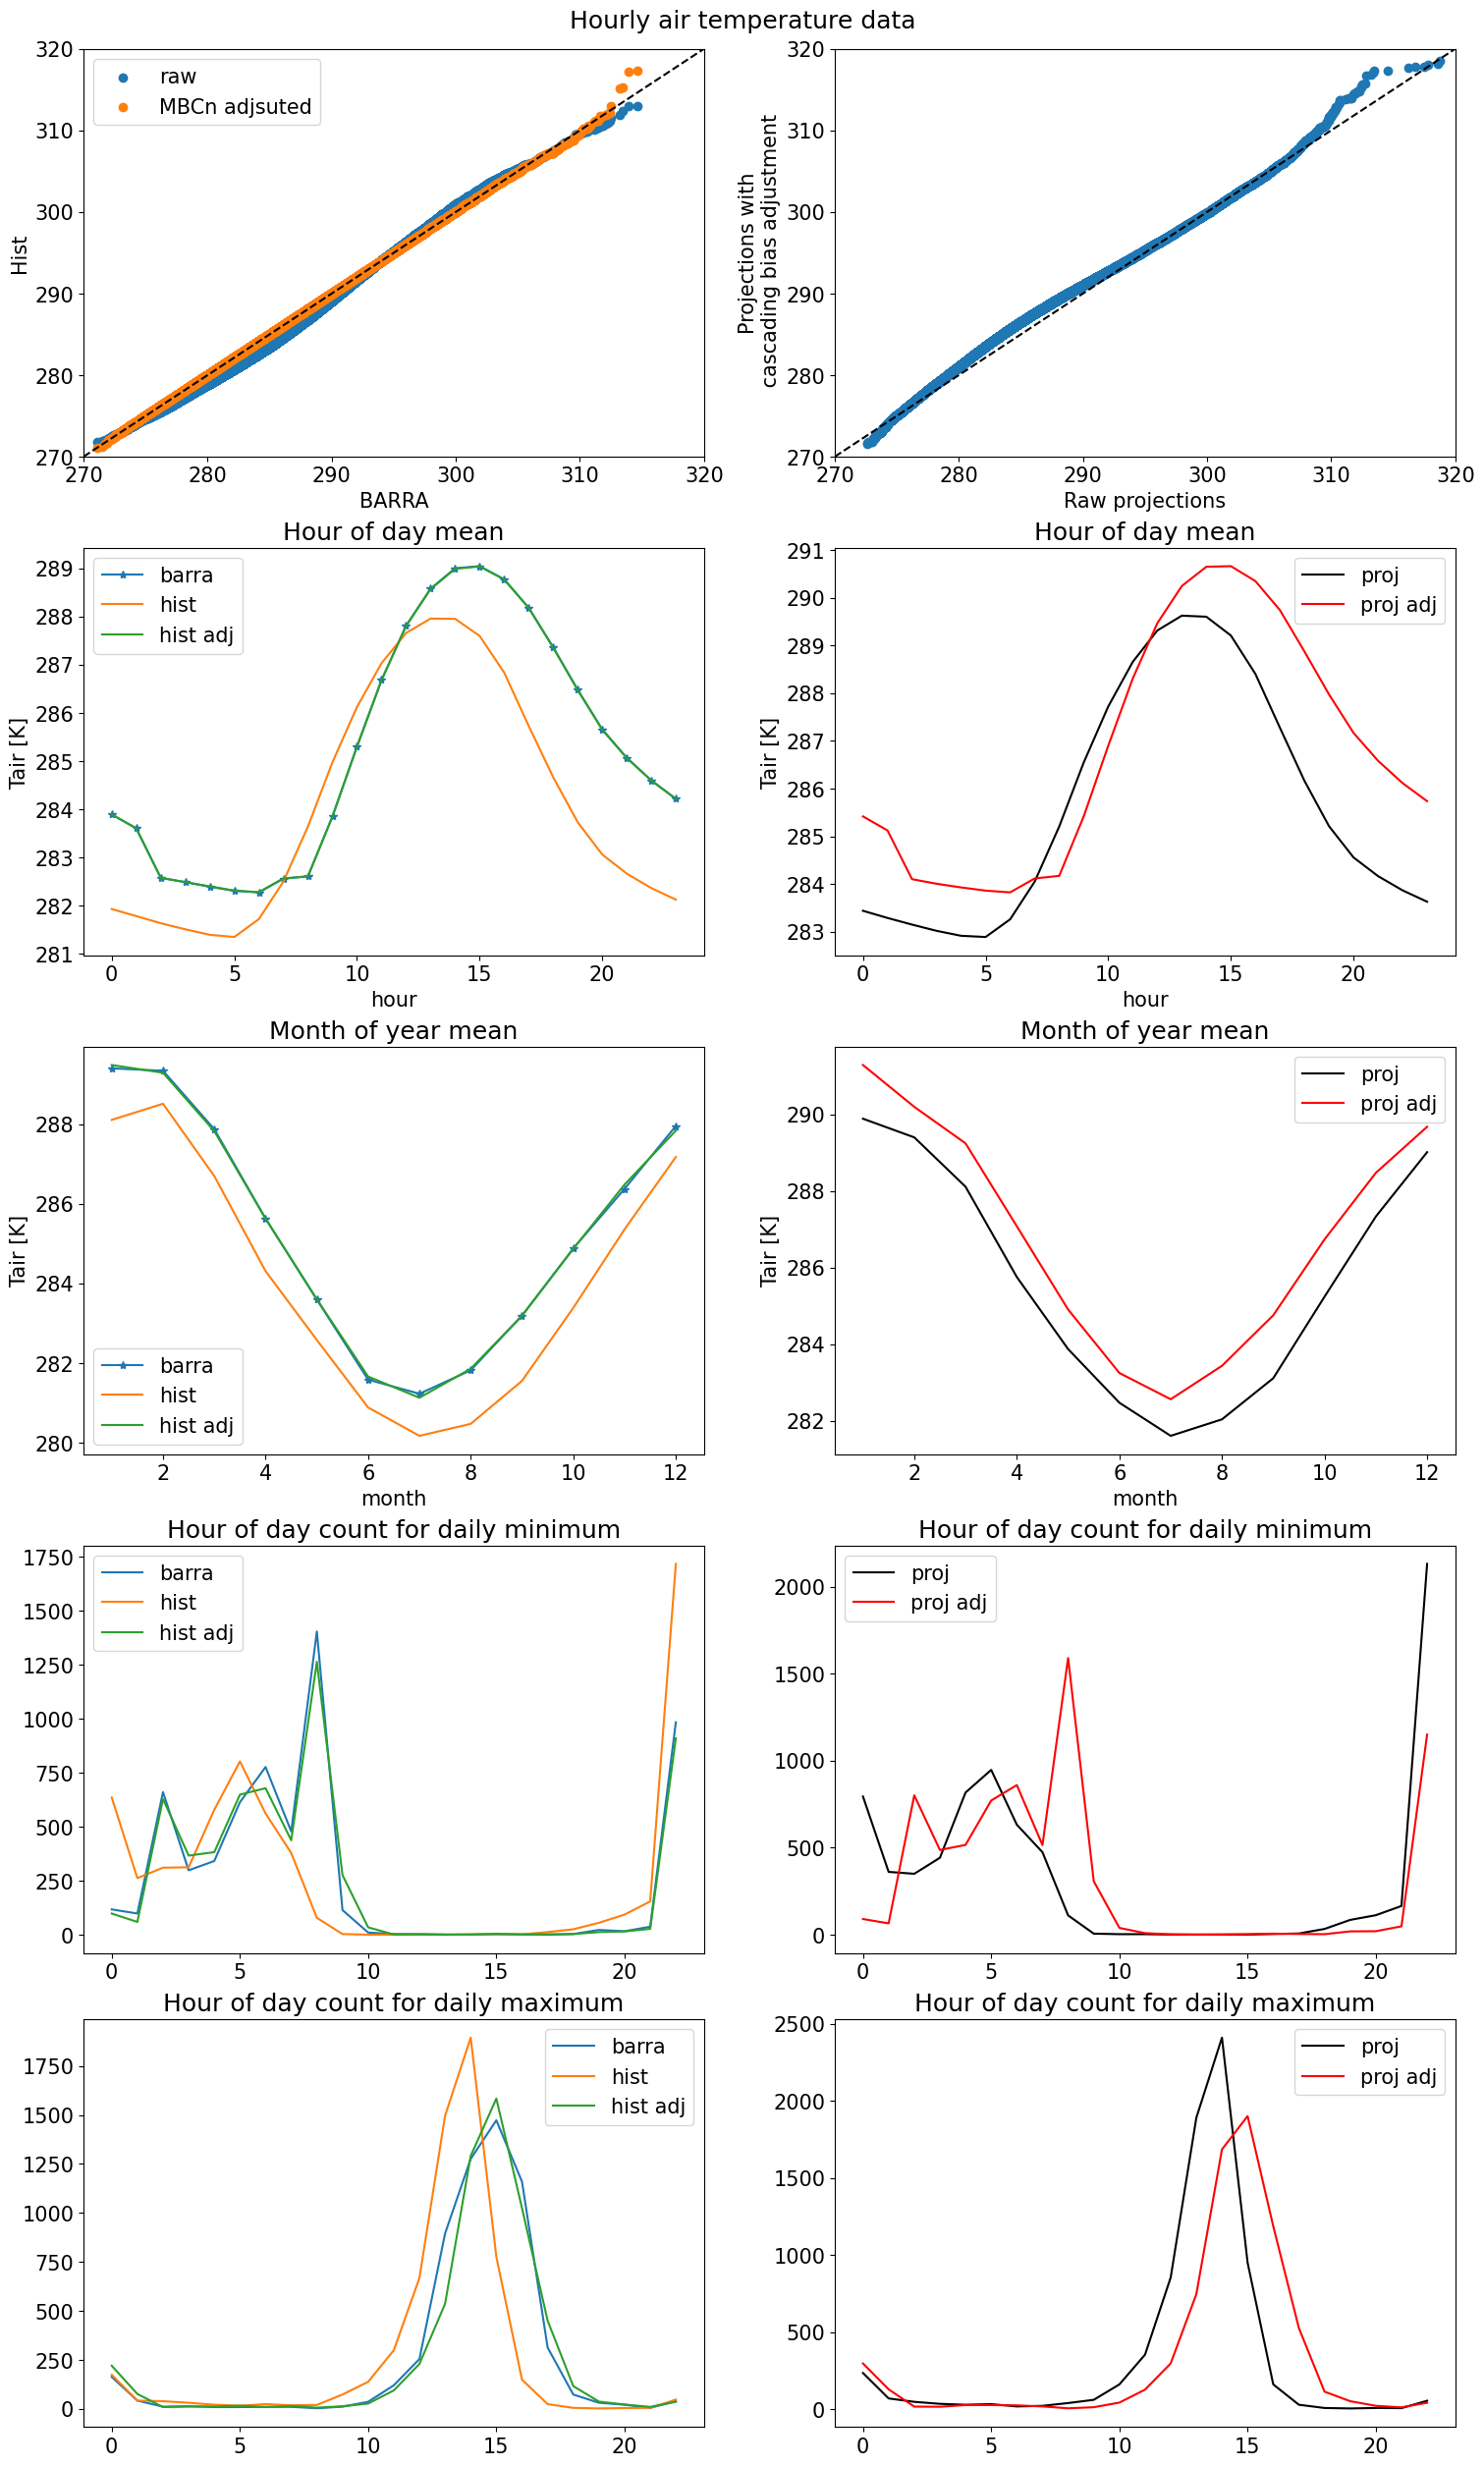

In [12]:
matplotlib.rcParams['figure.figsize'] = [15,25]
plt.rc('font', size=15)
fig,axs = plt.subplots(nrows=5, ncols=2,layout="constrained")

ax=axs[0,0]

ax.scatter(ds_barra.Tair.sortby(ds_barra.Tair),ds_model_hist.Tair.sortby(ds_model_hist.Tair),label='raw')
ax.scatter(ds_barra.Tair.sortby(ds_barra.Tair),scenh.Tair.sortby(scenh.Tair),label='MBCn adjsuted')
ax.plot([270,320],[270,320],'k--')
ax.set_xlim([270,320])
ax.set_ylim([270,320])
ax.set_xlabel('BARRA')
ax.set_ylabel('Hist')
ax.legend()

ax=axs[0,1]

ax.scatter(ds_model_proj.Tair.sortby(ds_model_proj.Tair),scens.Tair.sortby(scens.Tair),label='EQM adjsuted')
#ax.plot([0,20],[0,20],'k--')
ax.plot([270,320],[270,320],'k--')
ax.set_xlim([270,320])
ax.set_ylim([270,320])
ax.set_xlabel('Raw projections')
ax.set_ylabel('Projections with\n cascading bias adjustment')

ax=axs[1,0]
ds_barra.Tair.groupby(ds_barra.time.dt.hour).mean().plot(label='barra',ax=ax,marker='*')
ds_model_hist.Tair.groupby(ds_model_hist.time.dt.hour).mean().plot(label='hist',ax=ax)
scenh.Tair.groupby(scenh.Tair.time.dt.hour).mean().plot(label='hist adj',ax=ax)
ax.legend()
ax.set_title("Hour of day mean")

ax=axs[1,1]

ds_model_proj.Tair.groupby(ds_model_proj.time.dt.hour).mean().plot(label='proj',ax=ax,color='black')
scens.Tair.groupby(scens.Tair.time.dt.hour).mean().plot(label='proj adj',ax=ax,color='red')
ax.legend()
ax.set_title("Hour of day mean")

ax=axs[2,0]

ds_barra.Tair.groupby(ds_barra.time.dt.month).mean().plot(label='barra',ax=ax,marker='*')
ds_model_hist.Tair.groupby(ds_model_hist.time.dt.month).mean().plot(label='hist',ax=ax)
scenh.Tair.groupby(scenh.Tair.time.dt.month).mean().plot(label='hist adj',ax=ax)
ax.legend()
ax.set_title("Month of year mean")

ax=axs[2,1]
ds_model_proj.Tair.groupby(ds_model_proj.time.dt.month).mean().plot(label='proj',ax=ax,color='black')
scens.Tair.groupby(scens.Tair.time.dt.month).mean().plot(label='proj adj',ax=ax,color='red')
ax.legend()
ax.set_title("Month of year mean")

ax=axs[3,0]
ax.plot(np.histogram(ds_barra.Tair.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='barra')
ax.plot(np.histogram(ds_model_hist.Tair.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist')
ax.plot(np.histogram(scenh.Tair.resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist adj')


ax.legend()
ax.set_title("Hour of day count for daily minimum")

ax=axs[3,1]
ax.plot(np.histogram(ds_model_proj.Tair.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj',color='black')
ax.plot(np.histogram(scens.Tair.resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj adj',color='red')
ax.legend()
ax.set_title("Hour of day count for daily minimum")


ax=axs[4,0]
ax.plot(np.histogram(ds_barra.Tair.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='barra')
ax.plot(np.histogram(ds_model_hist.Tair.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist')
ax.plot(np.histogram(scenh.Tair.resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist adj')
ax.legend()
ax.set_title("Hour of day count for daily maximum")

ax=axs[4,1]
ax.plot(np.histogram(ds_model_proj.Tair.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj',color='black')
ax.plot(np.histogram(scens.Tair.resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj adj',color='red')
ax.legend()
ax.set_title("Hour of day count for daily maximum")

plt.suptitle('Hourly air temperature data')



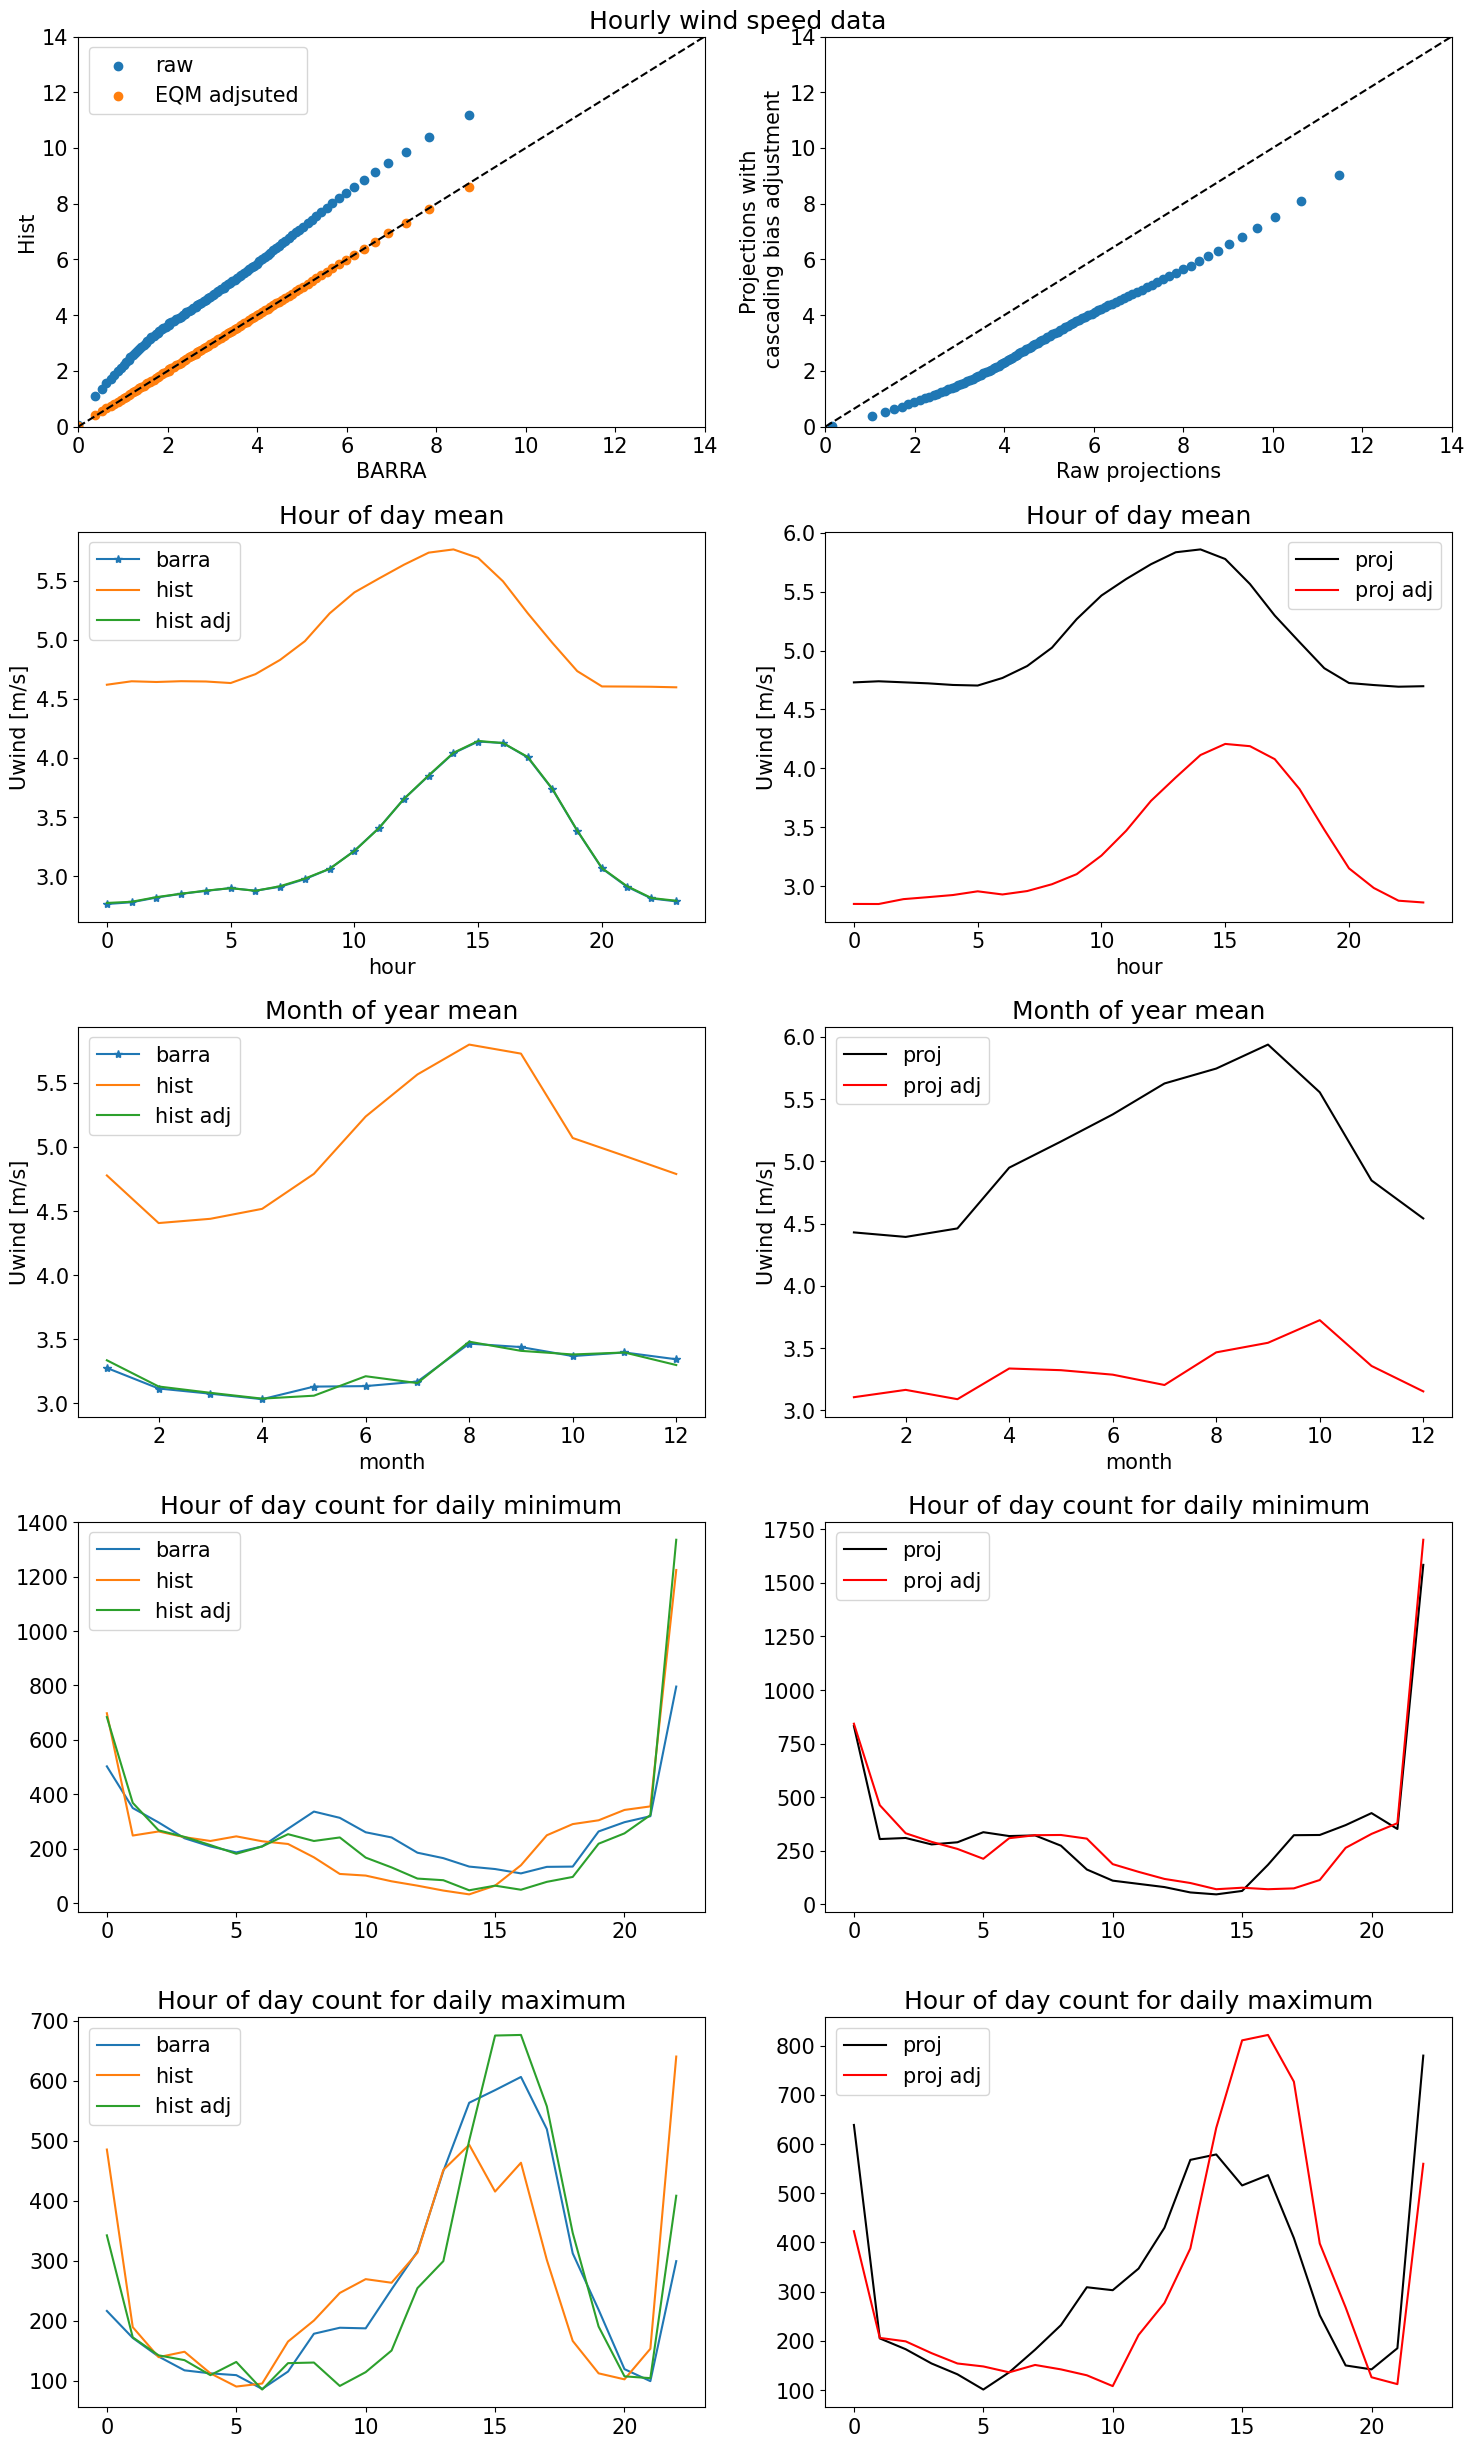

In [13]:
matplotlib.rcParams['figure.figsize'] = [15,25]
plt.rc('font', size=15)
fig,axs = plt.subplots(nrows=5, ncols=2,layout="constrained")

ax=axs[0,0]

ax.scatter(ds_barra.Uwind.compute().quantile(np.arange(0,1.01,0.01)),ds_model_hist.Uwind.compute().quantile(np.arange(0,1.01,0.01)),label='raw')
ax.scatter(ds_barra.Uwind.compute().quantile(np.arange(0,1.01,0.01)),scenh.Uwind.quantile(np.arange(0,1.01,0.01)),label='EQM adjsuted')
ax.plot([0,14],[0,14],'k--')
ax.set_xlim([0,14])
ax.set_ylim([0,14])
#ax.plot([0,20],[0,20],'k--')
ax.set_xlabel('BARRA')
ax.set_ylabel('Hist')
ax.legend()

ax=axs[0,1]

ax.scatter(ds_model_proj.Uwind.compute().quantile(np.arange(0,1.01,0.01)),scens.Uwind.compute().quantile(np.arange(0,1.01,0.01)),label='EQM adjsuted')
#ax.plot([0,20],[0,20],'k--')
ax.plot([0,14],[0,14],'k--')
ax.set_xlim([0,14])
ax.set_ylim([0,14])
ax.set_xlabel('Raw projections')
ax.set_ylabel('Projections with\n cascading bias adjustment')

ax=axs[1,0]
ds_barra.Uwind.groupby(ds_barra.time.dt.hour).mean().plot(label='barra',ax=ax,marker='*')
ds_model_hist.Uwind.groupby(ds_model_hist.time.dt.hour).mean().plot(label='hist',ax=ax)
scenh.Uwind.groupby(scenh.Uwind.time.dt.hour).mean().plot(label='hist adj',ax=ax)
ax.legend()
ax.set_title("Hour of day mean")

ax=axs[1,1]

ds_model_proj.Uwind.groupby(ds_model_proj.time.dt.hour).mean().plot(label='proj',ax=ax,color='black')
scens.Uwind.groupby(scens.Uwind.time.dt.hour).mean().plot(label='proj adj',ax=ax,color='red')
ax.legend()
ax.set_title("Hour of day mean")

ax=axs[2,0]

ds_barra.Uwind.groupby(ds_barra.time.dt.month).mean().plot(label='barra',ax=ax,marker='*')
ds_model_hist.Uwind.groupby(ds_model_hist.time.dt.month).mean().plot(label='hist',ax=ax)
scenh.Uwind.groupby(scenh.Uwind.time.dt.month).mean().plot(label='hist adj',ax=ax)
ax.legend()
ax.set_title("Month of year mean")

ax=axs[2,1]
ds_model_proj.Uwind.groupby(ds_model_proj.time.dt.month).mean().plot(label='proj',ax=ax,color='black')
scens.Uwind.groupby(scens.Uwind.time.dt.month).mean().plot(label='proj adj',ax=ax,color='red')
ax.legend()
ax.set_title("Month of year mean")

ax=axs[3,0]
ax.plot(np.histogram(ds_barra.Uwind.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='barra')
ax.plot(np.histogram(ds_model_hist.Uwind.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist')
ax.plot(np.histogram(scenh.Uwind.resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist adj')
ax.legend()
ax.set_title("Hour of day count for daily minimum")

ax=axs[3,1]
ax.plot(np.histogram(ds_model_proj.Uwind.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj',color='black')
ax.plot(np.histogram(scens.Uwind.resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj adj',color='red')
ax.legend()
ax.set_title("Hour of day count for daily minimum")


ax=axs[4,0]
ax.plot(np.histogram(ds_barra.Uwind.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='barra')
ax.plot(np.histogram(ds_model_hist.Uwind.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist')
ax.plot(np.histogram(scenh.Uwind.resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist adj')
ax.legend()
ax.set_title("Hour of day count for daily maximum")

ax=axs[4,1]
ax.plot(np.histogram(ds_model_proj.Uwind.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj',color='black')
ax.plot(np.histogram(scens.Uwind.resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj adj',color='red')
ax.legend()
ax.set_title("Hour of day count for daily maximum")

plt.suptitle('Hourly wind speed data')
plt.tight_layout()


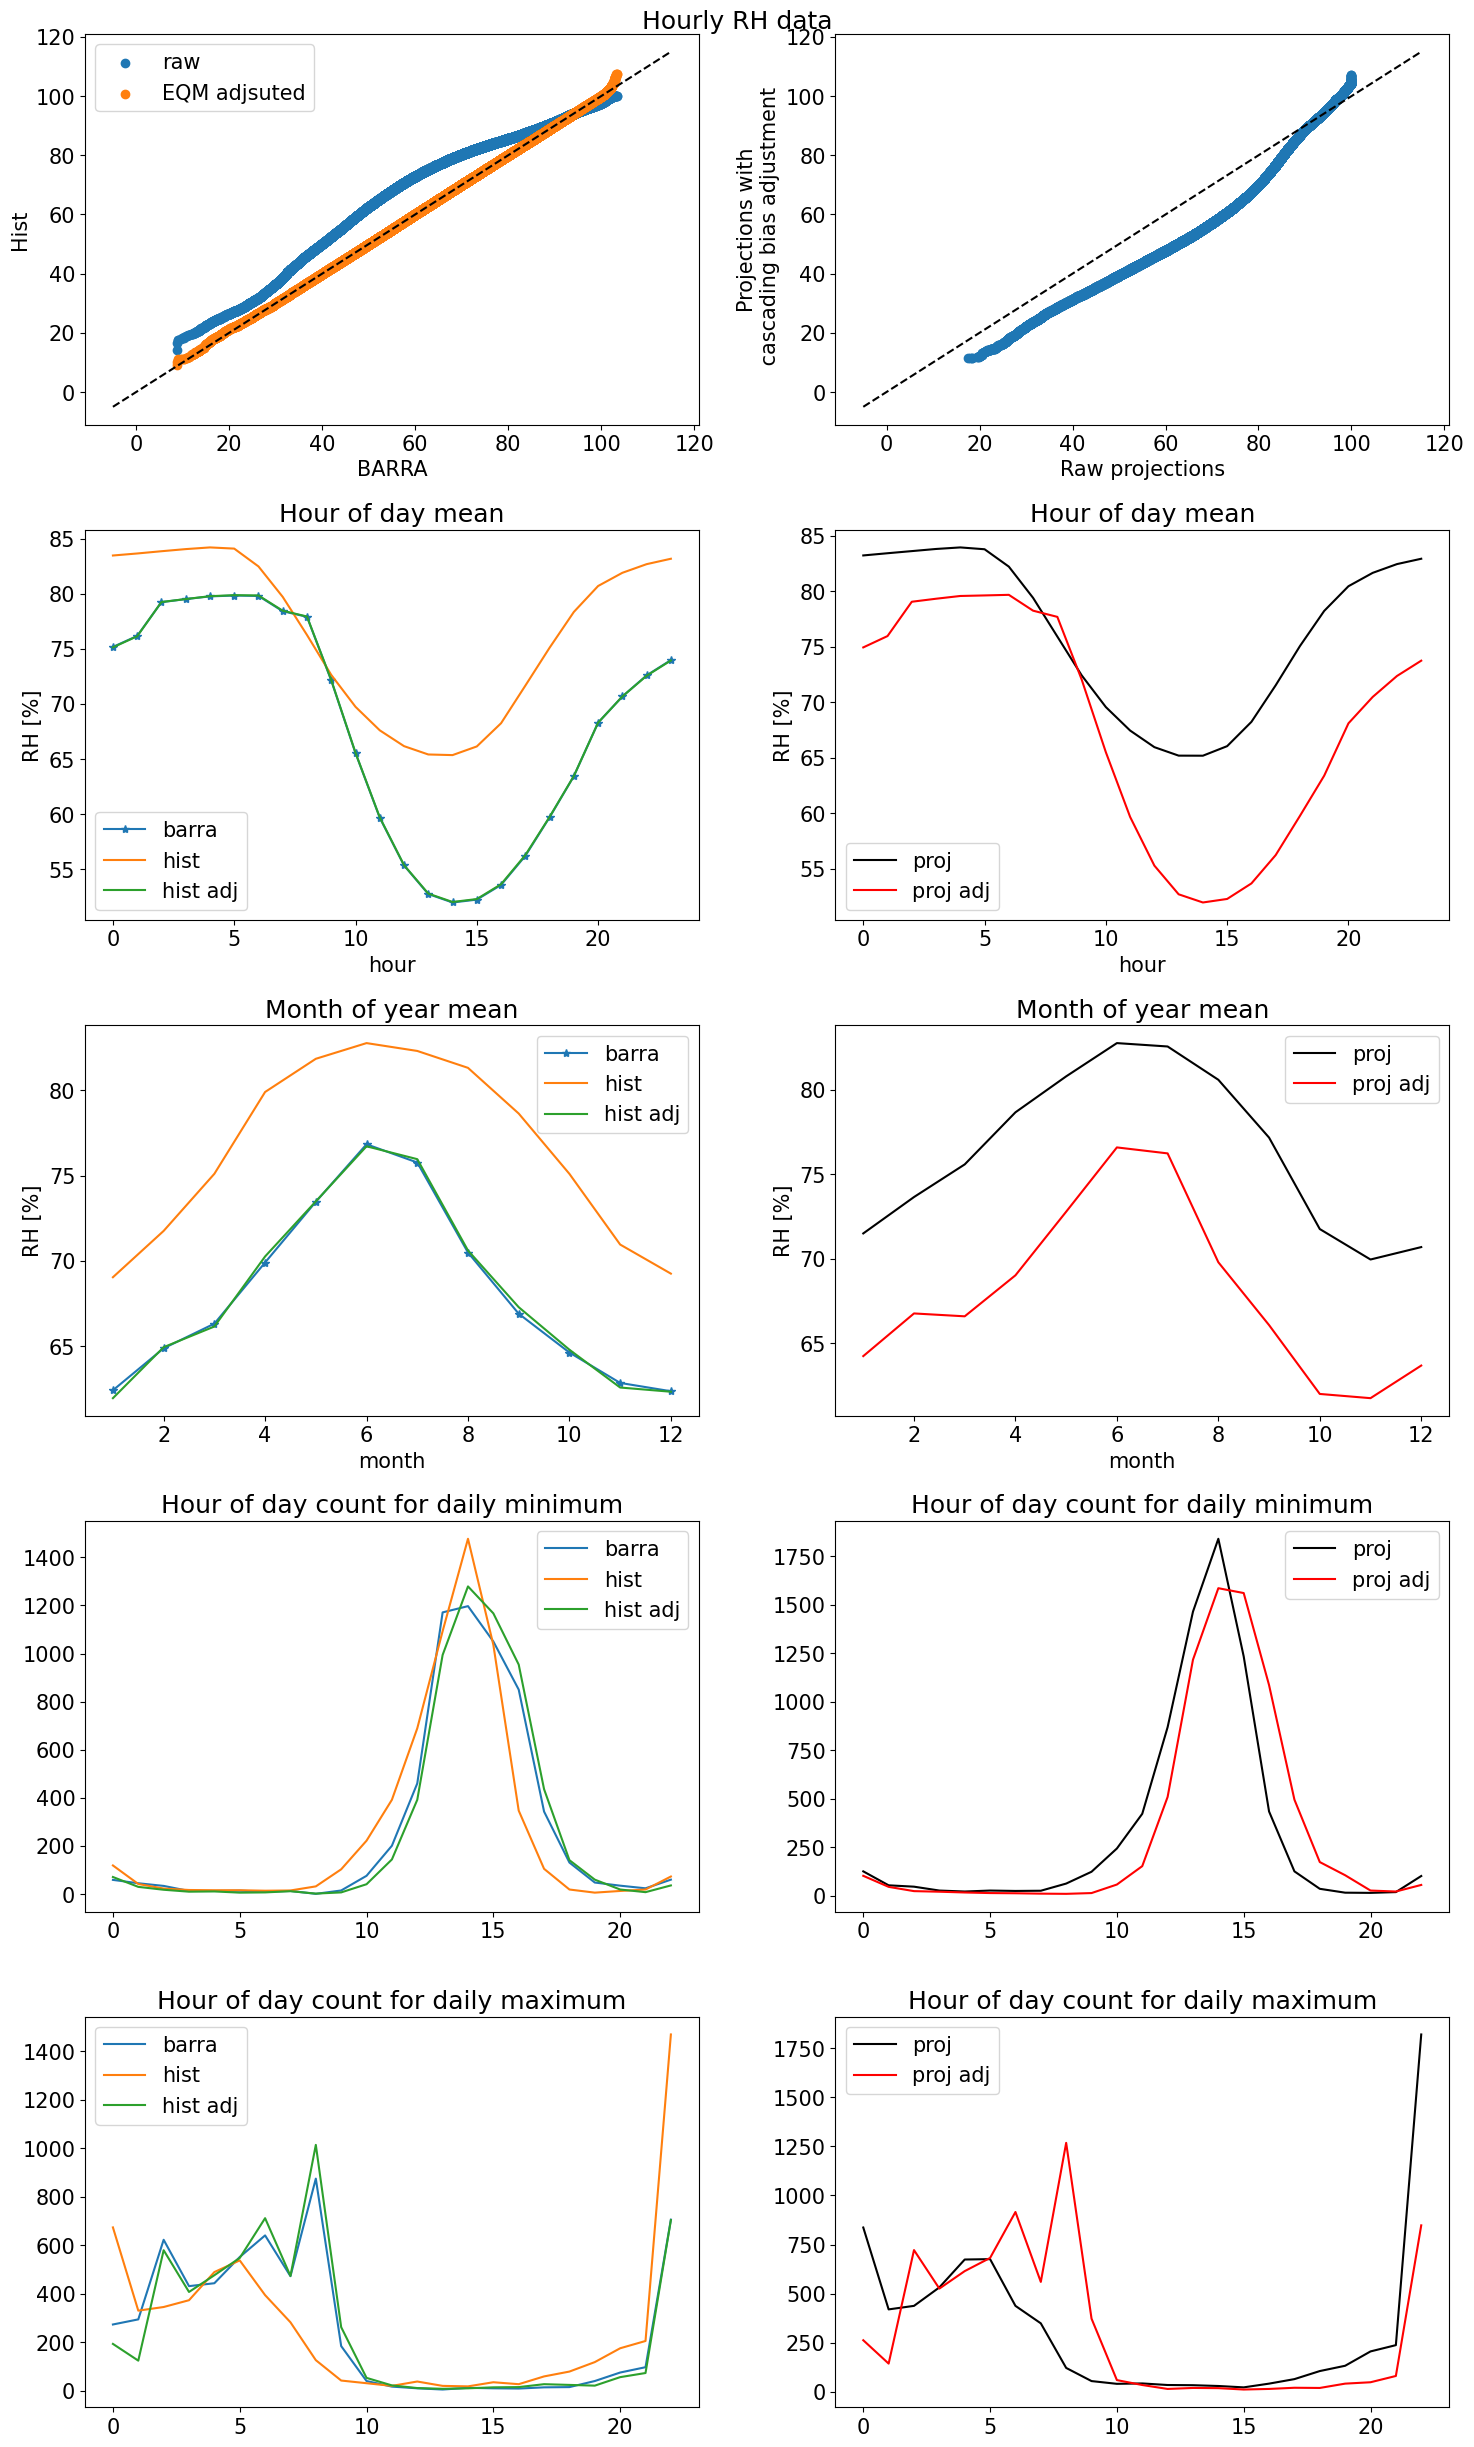

In [14]:
matplotlib.rcParams['figure.figsize'] = [15,25]
plt.rc('font', size=15)
fig,axs = plt.subplots(nrows=5, ncols=2,layout="constrained")

ax=axs[0,0]

ax.scatter(ds_barra.RH.sortby(ds_barra.RH),ds_model_hist.RH.sortby(ds_model_hist.RH),label='raw')
ax.scatter(ds_barra.RH.sortby(ds_barra.RH),scenh.RH.sortby(scenh.RH),label='EQM adjsuted')
ax.plot([-5,115],[-5,115],'k--')
# ax.set_xlim([-5,115])
# ax.set_ylim([-5,115])
#ax.plot([0,20],[0,20],'k--')
ax.set_xlabel('BARRA')
ax.set_ylabel('Hist')
ax.legend()

ax=axs[0,1]

ax.scatter(ds_model_proj.RH.sortby(ds_model_proj.RH),scens.RH.sortby(scens.RH),label='EQM adjsuted')
#ax.plot([0,20],[0,20],'k--')
ax.plot([-5,115],[-5,115],'k--')
# ax.set_xlim([-5,115])
# ax.set_ylim([-5,115])
ax.set_xlabel('Raw projections')
ax.set_ylabel('Projections with\n cascading bias adjustment')

ax=axs[1,0]
ds_barra.RH.groupby(ds_barra.time.dt.hour).mean().plot(label='barra',ax=ax,marker='*')
ds_model_hist.RH.groupby(ds_model_hist.time.dt.hour).mean().plot(label='hist',ax=ax)
scenh.RH.groupby(scenh.RH.time.dt.hour).mean().plot(label='hist adj',ax=ax)
ax.legend()
ax.set_title("Hour of day mean")

ax=axs[1,1]

ds_model_proj.RH.groupby(ds_model_proj.time.dt.hour).mean().plot(label='proj',ax=ax,color='black')
scens.RH.groupby(scens.RH.time.dt.hour).mean().plot(label='proj adj',ax=ax,color='red')
ax.legend()
ax.set_title("Hour of day mean")

ax=axs[2,0]

ds_barra.RH.groupby(ds_barra.time.dt.month).mean().plot(label='barra',ax=ax,marker='*')
ds_model_hist.RH.groupby(ds_model_hist.time.dt.month).mean().plot(label='hist',ax=ax)
scenh.RH.groupby(scenh.RH.time.dt.month).mean().plot(label='hist adj',ax=ax)
ax.legend()
ax.set_title("Month of year mean")

ax=axs[2,1]
ds_model_proj.RH.groupby(ds_model_proj.time.dt.month).mean().plot(label='proj',ax=ax,color='black')
scens.RH.groupby(scens.RH.time.dt.month).mean().plot(label='proj adj',ax=ax,color='red')
ax.legend()
ax.set_title("Month of year mean")

ax=axs[3,0]
ax.plot(np.histogram(ds_barra.RH.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='barra')
ax.plot(np.histogram(ds_model_hist.RH.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist')
ax.plot(np.histogram(scenh.RH.resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist adj')
ax.legend()
ax.set_title("Hour of day count for daily minimum")

ax=axs[3,1]
ax.plot(np.histogram(ds_model_proj.RH.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj',color='black')
ax.plot(np.histogram(scens.RH.resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj adj',color='red')
ax.legend()
ax.set_title("Hour of day count for daily minimum")


ax=axs[4,0]
ax.plot(np.histogram(ds_barra.RH.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='barra')
ax.plot(np.histogram(ds_model_hist.RH.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist')
ax.plot(np.histogram(scenh.RH.resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist adj')
ax.legend()
ax.set_title("Hour of day count for daily maximum")

ax=axs[4,1]
ax.plot(np.histogram(ds_model_proj.RH.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj',color='black')
ax.plot(np.histogram(scens.RH.resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj adj',color='red')
ax.legend()
ax.set_title("Hour of day count for daily maximum")

plt.suptitle('Hourly RH data')
plt.tight_layout()


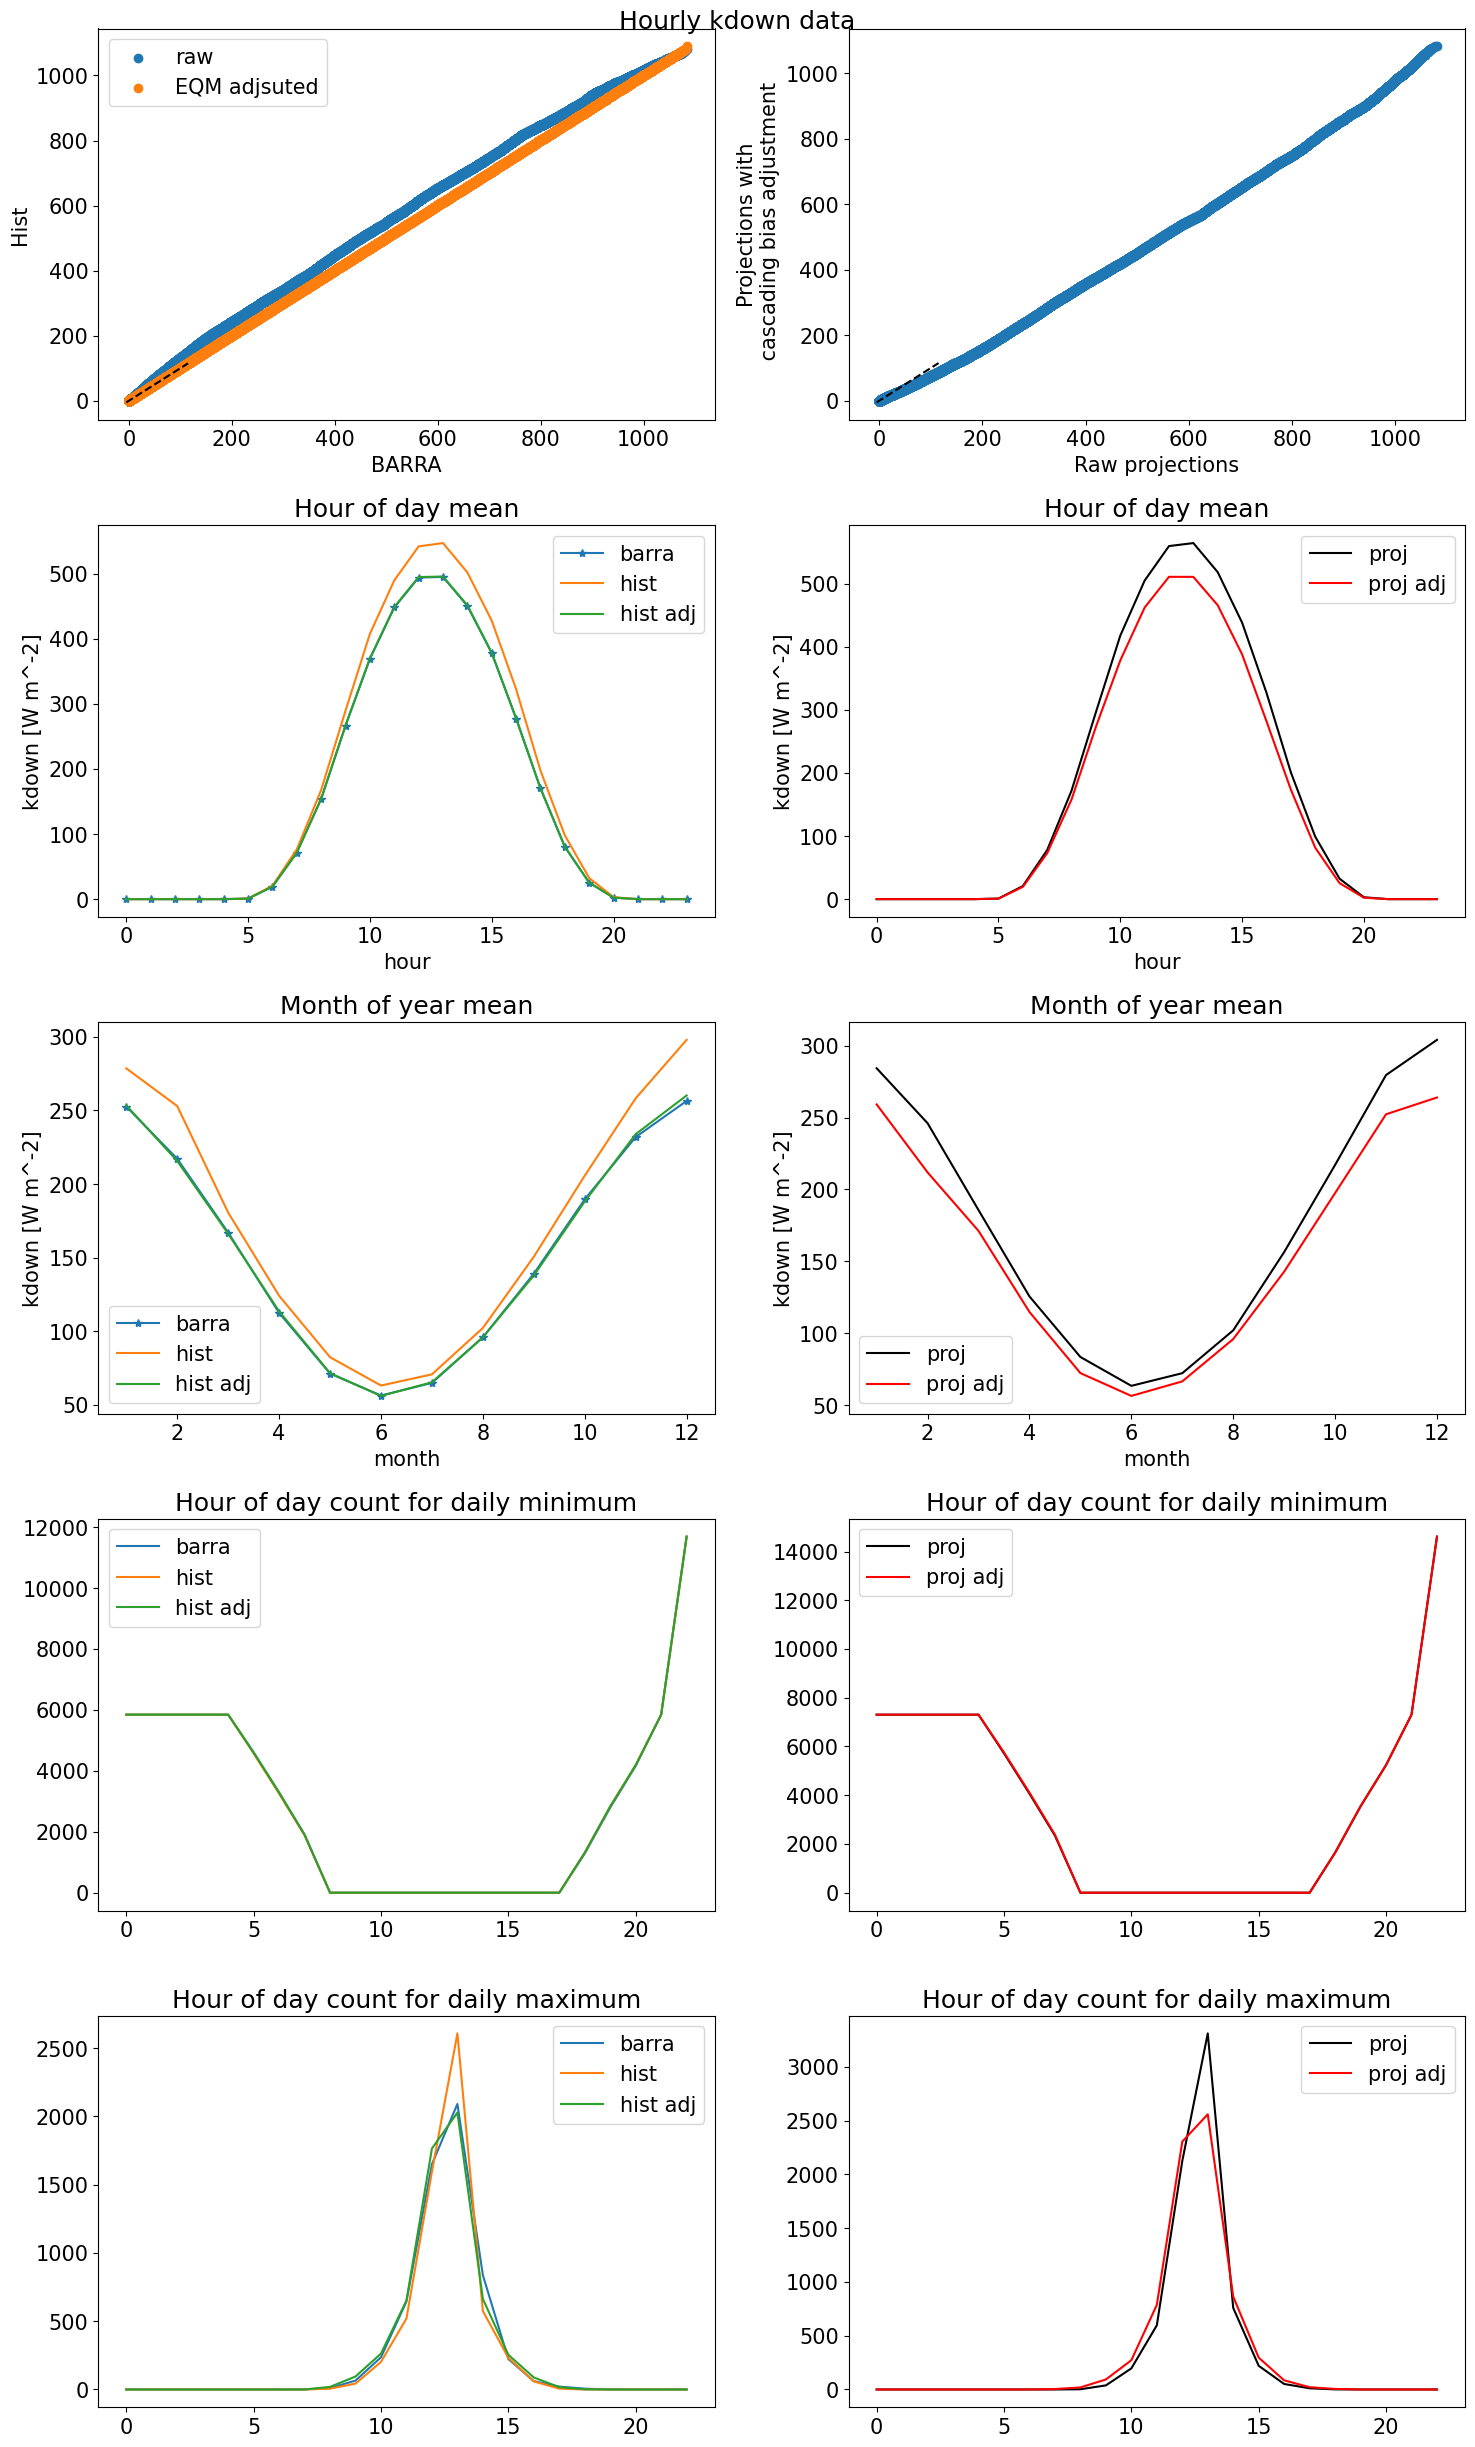

In [15]:
matplotlib.rcParams['figure.figsize'] = [15,25]
plt.rc('font', size=15)
fig,axs = plt.subplots(nrows=5, ncols=2,layout="constrained")

ax=axs[0,0]

ax.scatter(ds_barra.kdown.sortby(ds_barra.kdown),ds_model_hist.kdown.sortby(ds_model_hist.kdown),label='raw')
ax.scatter(ds_barra.kdown.sortby(ds_barra.kdown),scenh.kdown.sortby(scenh.kdown),label='EQM adjsuted')
ax.plot([-5,115],[-5,115],'k--')
# ax.set_xlim([-5,115])
# ax.set_ylim([-5,115])
#ax.plot([0,20],[0,20],'k--')
ax.set_xlabel('BARRA')
ax.set_ylabel('Hist')
ax.legend()

ax=axs[0,1]

ax.scatter(ds_model_proj.kdown.sortby(ds_model_proj.kdown),scens.kdown.sortby(scens.kdown),label='EQM adjsuted')
#ax.plot([0,20],[0,20],'k--')
ax.plot([-5,115],[-5,115],'k--')
# ax.set_xlim([-5,115])
# ax.set_ylim([-5,115])
ax.set_xlabel('Raw projections')
ax.set_ylabel('Projections with\n cascading bias adjustment')

ax=axs[1,0]
ds_barra.kdown.groupby(ds_barra.time.dt.hour).mean().plot(label='barra',ax=ax,marker='*')
ds_model_hist.kdown.groupby(ds_model_hist.time.dt.hour).mean().plot(label='hist',ax=ax)
scenh.kdown.groupby(scenh.kdown.time.dt.hour).mean().plot(label='hist adj',ax=ax)
ax.legend()
ax.set_title("Hour of day mean")

ax=axs[1,1]

ds_model_proj.kdown.groupby(ds_model_proj.time.dt.hour).mean().plot(label='proj',ax=ax,color='black')
scens.kdown.groupby(scens.kdown.time.dt.hour).mean().plot(label='proj adj',ax=ax,color='red')
ax.legend()
ax.set_title("Hour of day mean")

ax=axs[2,0]

ds_barra.kdown.groupby(ds_barra.time.dt.month).mean().plot(label='barra',ax=ax,marker='*')
ds_model_hist.kdown.groupby(ds_model_hist.time.dt.month).mean().plot(label='hist',ax=ax)
scenh.kdown.groupby(scenh.kdown.time.dt.month).mean().plot(label='hist adj',ax=ax)
ax.legend()
ax.set_title("Month of year mean")

ax=axs[2,1]
ds_model_proj.kdown.groupby(ds_model_proj.time.dt.month).mean().plot(label='proj',ax=ax,color='black')
scens.kdown.groupby(scens.kdown.time.dt.month).mean().plot(label='proj adj',ax=ax,color='red')
ax.legend()
ax.set_title("Month of year mean")

ax=axs[3,0]
ax.plot(np.histogram(ds_barra.kdown.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='barra')
ax.plot(np.histogram(ds_model_hist.kdown.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist')
ax.plot(np.histogram(scenh.kdown.resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist adj')
ax.legend()
ax.set_title("Hour of day count for daily minimum")

ax=axs[3,1]
ax.plot(np.histogram(ds_model_proj.kdown.compute().resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj',color='black')
ax.plot(np.histogram(scens.kdown.resample(time='1D').map(lambda x : x.time[x==x.min()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj adj',color='red')
ax.legend()
ax.set_title("Hour of day count for daily minimum")


ax=axs[4,0]
ax.plot(np.histogram(ds_barra.kdown.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='barra')
ax.plot(np.histogram(ds_model_hist.kdown.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist')
ax.plot(np.histogram(scenh.kdown.resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='hist adj')
ax.legend()
ax.set_title("Hour of day count for daily maximum")

ax=axs[4,1]
ax.plot(np.histogram(ds_model_proj.kdown.compute().resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj',color='black')
ax.plot(np.histogram(scens.kdown.resample(time='1D').map(lambda x : x.time[x==x.max()]).dt.hour,bins=np.arange(0,24,1))[0],label='proj adj',color='red')
ax.legend()
ax.set_title("Hour of day count for daily maximum")

plt.suptitle('Hourly kdown data')
plt.tight_layout()


The data can now be used to generate SOLWEIG compatible meteorology files.

### References

Cannon, A.J., Sobie, S.R. and Murdock, T.Q., 2015. Bias correction of GCM precipitation by quantile mapping: how well do methods preserve changes in quantiles and extremes?. Journal of Climate, 28(17), pp.6938-6959.

Cannon, A.J., 2018. Multivariate quantile mapping bias correction: an N-dimensional probability density function transform for climate model simulations of multiple variables. Climate dynamics, 50, pp.31-49.

Clarke, J.M., Grose, M., Thatcher, M., Hernaman, V., Heady, C., Round, V., Rafter, T., Trenham, C. and Wilson, L., 2019. Victorian climate projections 2019 technical report. Melbourne Australia.

Faghih, M., Brissette, F. and Sabeti, P., 2022. Impact of correcting sub-daily climate model biases for hydrological studies. Hydrology and Earth System Sciences, 26(6), pp.1545-1563.

Harris, R; Remenyi, Tomas; Rollins, Dean; Love, Peter; Earl, Nick; Bindoff, Nathaniel (2020). Australia's wine future - climate information  for adaptation to change. University Of Tasmania. Journal contribution. https://hdl.handle.net/102.100.100/23026310.v1

Su, C.H., Eizenberg, N., Jakob, D., Fox-Hughes, P., Steinle, P., White, C.J. and Franklin, C., 2021. BARRA v1. 0: kilometre-scale downscaling of an Australian regional atmospheric reanalysis over four midlatitude domains. Geoscientific Model Development, 14(7), pp.4357-4378.